In [1]:
import pandas as pd
import numpy as np
from sql_export import sql_connection, sql_connection_close
import torch
from torch.utils.data import DataLoader
from torchvision import transforms
import os
from dotenv import load_dotenv
# from concurrent import futures
import matplotlib.pyplot as plt
from azure_blob_dataset import AzureBlobDataset
import random
from skimage.transform import rotate
from dl_models import CNNFromScratch, get_efficientnet
import time
import torch.optim as optim
import torch.nn as nn
from torchvision.transforms.functional import to_pil_image
from PIL import Image



load_dotenv()

True

## Set PATH for Azure SQL in Jupyter environment

In [2]:
# Set Apple Silicon paths (for M1/M2 Macs)
# For some reason we need to manually set paths for the odbcinst file so jupyter file can connect to Azure SQL
# Did not need to do this for python code

os.environ['ODBCSYSINI'] = os.getenv('ETC')
os.environ['ODBCINSTINI'] = os.getenv("INI")
os.environ['DYLD_LIBRARY_PATH'] = os.getenv("LIB")

In [3]:
!odbcinst -q -d -n "ODBC Driver 18 for SQL Server"

[ODBC Driver 18 for SQL Server]
Description=Microsoft ODBC Driver 18 for SQL Server
Driver=/opt/homebrew/lib/libmsodbcsql.18.dylib
UsageCount=2


## Azure SQL Database Retrieval to memory

In [4]:
sql_connection_close()
sql_query = "SELECT * FROM dbo.galaxy_target_values"
conn, cursor = sql_connection()
target_df = pd.read_sql(sql_query, conn)
target_df
sql_connection_close()

Connection to SQL server successful.
SQL Server version:  Microsoft SQL Azure (RTM) - 12.0.2000.8 
	Feb  9 2025 20:57:20 
	Copyright (C) 2024 Microsoft Corporation

SQL connection closed.
Connection to SQL server successful.
SQL Server version:  Microsoft SQL Azure (RTM) - 12.0.2000.8 
	Feb  9 2025 20:57:20 
	Copyright (C) 2024 Microsoft Corporation



/var/folders/51/q7wk1sc54ms0xz7vq4j4k4g80000gn/T/ipykernel_5054/3625703550.py:4: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  target_df = pd.read_sql(sql_query, conn)


Connection to SQL server successful.
SQL Server version:  Microsoft SQL Azure (RTM) - 12.0.2000.8 
	Feb  9 2025 20:57:20 
	Copyright (C) 2024 Microsoft Corporation

SQL connection closed.


In [5]:
target_df

,GalaxyID,Class1.1,Class1.2,Class1.3,Class2.1,Class2.2,Class3.1,Class3.2,Class4.1,Class4.2,...,Class9.3,Class10.1,Class10.2,Class10.3,Class11.1,Class11.2,Class11.3,Class11.4,Class11.5,Class11.6
0,100008,0.383147,0.616853,0.000000,0.000000,0.616853,0.038452,0.578401,0.418398,0.198455,...,0.000000,0.279952,0.138445,0.000000,0.000000,0.092886,0.000000,0.000000,0.0,0.325512
1,100023,0.327001,0.663777,0.009222,0.031178,0.632599,0.467370,0.165229,0.591328,0.041271,...,0.018764,0.000000,0.131378,0.459950,0.000000,0.591328,0.000000,0.000000,0.0,0.000000
2,100053,0.765717,0.177352,0.056931,0.000000,0.177352,0.000000,0.177352,0.000000,0.177352,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
3,100078,0.693377,0.238564,0.068059,0.000000,0.238564,0.109493,0.129071,0.189098,0.049466,...,0.000000,0.094549,0.000000,0.094549,0.189098,0.000000,0.000000,0.000000,0.0,0.000000
4,100090,0.933839,0.000000,0.066161,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61573,999948,0.510379,0.489621,0.000000,0.059207,0.430414,0.000000,0.430414,0.226257,0.204157,...,0.000000,0.226257,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.226257
61574,999950,0.901216,0.098784,0.000000,0.000000,0.098784,0.000000,0.098784,0.000000,0.098784,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
61575,999958,0.202841,0.777376,0.019783,0.116962,0.660414,0.067245,0.593168,0.140022,0.520391,...,0.000000,0.000000,0.090673,0.049349,0.000000,0.067726,0.000000,0.000000,0.0,0.072296
61576,999964,0.091000,0.909000,0.000000,0.045450,0.863550,0.022452,0.841098,0.795330,0.068220,...,0.000000,0.068398,0.318132,0.408799,0.227464,0.408799,0.090668,0.023065,0.0,0.045334


## Transformations

In [6]:
class RandomRotation:
    def __init__(self, angles=[0, 90, 180, 270]):
        self.angles = angles
    
    def __call__(self, img):
        # If img is a PIL Image, convert it to a numpy array.
        if isinstance(img, Image.Image):
            img = np.array(img)
        angle = random.choice(self.angles)
        rotated = rotate(img, angle, resize=False, mode='edge')
        # Convert rotated image back to a PIL Image
        return to_pil_image(rotated)

In [7]:
#transforming the images to tensor and normalizing 
transform_training = transforms.Compose([
    transforms.RandomResizedCrop(size=224, scale=(170/424, 240/424), ratio=(1.0, 1.0)), # scale jittering from center cropping
    RandomRotation(angles = [0, 90, 180, 270]),  # rotate the image on 4 quadrant angles
    transforms.RandomHorizontalFlip(p=0.5), # flip image about horizontal axis 
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),

    transforms.ToTensor(),                # converts numpy array (H,W,C) in [0,1] to tensor (C,H,W)
    # These values were computed over the ImageNet training set. ImageNet is a huge dataset of natural images and has become the standard benchmark
    #  for many image classification models.
    transforms.Normalize(                 # normalized value = (pixel value - mean)/std
        mean=[0.485, 0.456, 0.406],       # These numbers represent the average pixel intensity (scaled between 0 and 1) for each color channel across the entire ImageNet training set.
        std=[0.229, 0.224, 0.225]         # These values indicate how much the pixel intensities vary (standard deviation) from the mean in each channel.
    )
])

In [8]:
# Define evaluation transforms (deterministic)
transform_eval = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225])
])

### Dataset Split (80/10/10)

In [9]:
# doing this makes it easire to lookup target values for corresponding images at O(1) time complexity
# Better integration with DataLoader
target_dict = dict(zip(target_df['GalaxyID'], target_df.drop('GalaxyID', axis=1).values))

In [10]:
full_training_dataset = AzureBlobDataset(train=True, transform=transform_training, target_dict=target_dict, img_size=(424, 424))
full_eval_dataset = AzureBlobDataset(train=True, transform=transform_eval, target_dict=target_dict, img_size=(424, 424))

In [11]:
# Get the same split indices for both (you can generate indices and then create Subset objects)
total_size = len(full_training_dataset)
indices = list(range(total_size))
train_split = int(0.8 * total_size)
val_split = int(0.9 * total_size)


train_dataset = torch.utils.data.Subset(full_training_dataset, indices[:train_split])
val_dataset = torch.utils.data.Subset(full_eval_dataset, indices[train_split:val_split])
test_dataset = torch.utils.data.Subset(full_eval_dataset, indices[val_split:])

print(f"Dataset split: {len(train_dataset)} train, {len(val_dataset)} val, {len(test_dataset)} test.")

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
val_loader   = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)
test_loader  = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)

Dataset split: 49262 train, 6158 val, 6158 test.


### Sample view

In [12]:
def visualize_samples(dataset, num_samples=5):
    fig, axes = plt.subplots(1, num_samples, figsize=(20, 5))
    
    # Handle case when num_samples is 1
    if num_samples == 1:
        axes = [axes]
    
    for i, ax in enumerate(axes):
        # Get sample
        sample = dataset[i]
        
        # Convert tensor to numpy array and denormalize if needed
        image = sample['image'].numpy()
        
        # For PyTorch CHW format -> Matplotlib HWC format
        if image.shape[0] == 3:  # RGB
            image = image.transpose(1, 2, 0)
        elif image.shape[0] == 1:  # Grayscale
            image = image.squeeze(0)
        
        # Clip values to valid range for display
        image = np.clip(image, 0, 1)
        
        # Show image
        ax.imshow(image)
        ax.axis('off')
        
        # Create title with metadata
        title = f"Galaxy ID: {sample['galaxy_id']}"
        if 'target' in sample:
            title += f"\nTarget: {sample['target'].numpy().round(2)}"
        
        ax.set_title(title, fontsize=10)
    
    plt.tight_layout()
    plt.show()

In [13]:
### TEST ### (remove after done)

# blerg = AzureBlobDataset(train=True, transform=None, target_dict=target_dict, img_size=(424, 424))
# visualize_samples(blerg, num_samples=5)

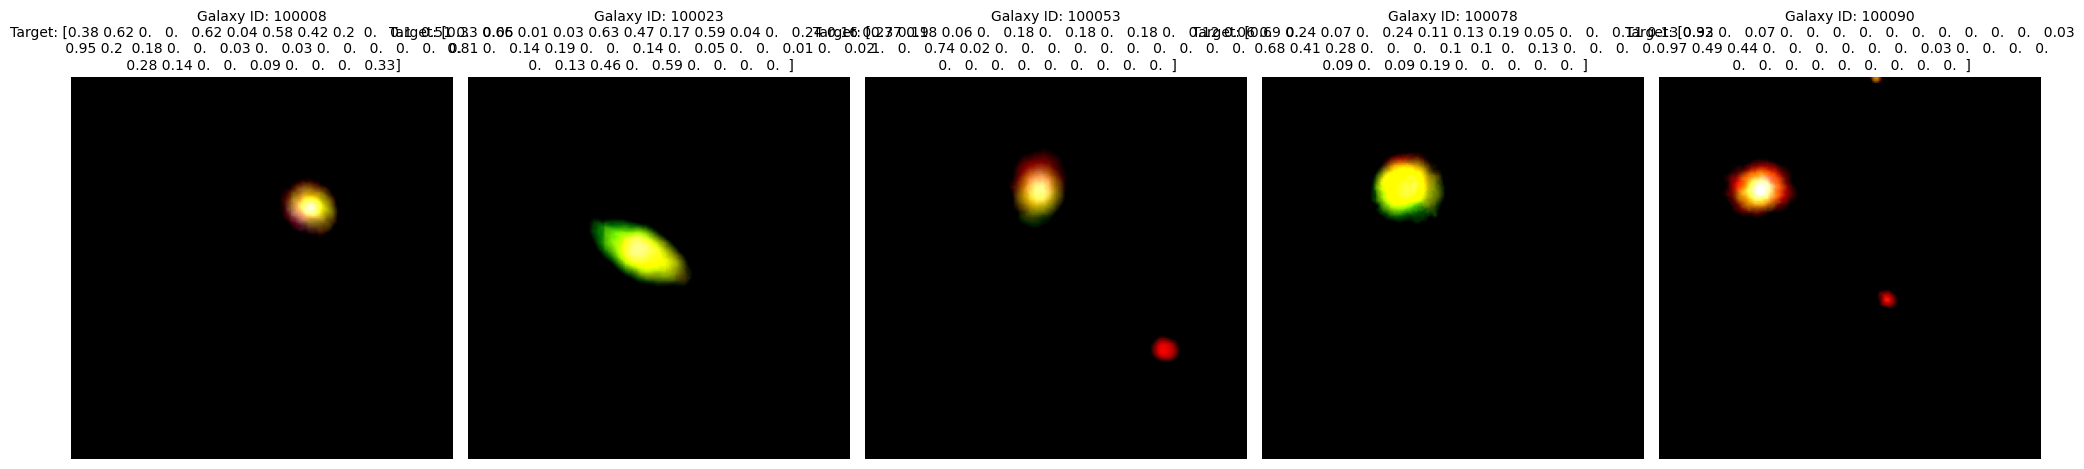

In [14]:
# Visualize first 5 training samples
visualize_samples(train_dataset, num_samples=5)

## DL Model 

### Training Function

In [15]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, device, save_path='best_model.pt'):
   
    best_val_loss = float('inf')
    train_losses = []
    val_losses = []
    
    for epoch in range(1, num_epochs+1):
        start_time = time.time()
        model.train()
        running_loss = 0.0
        
        for batch in train_loader:
            inputs = batch['image'].to(device)
            targets = batch['target'].to(device)  # Expected shape: [batch_size, 37]
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * inputs.size(0)
        
        epoch_train_loss = running_loss / len(train_loader.dataset)
        train_losses.append(epoch_train_loss)
        
        # Validation Phase
        model.eval()
        running_val_loss = 0.0
        with torch.no_grad():
            for batch in val_loader:
                inputs = batch['image'].to(device)
                targets = batch['target'].to(device)
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                running_val_loss += loss.item() * inputs.size(0)
        epoch_val_loss = running_val_loss / len(val_loader.dataset)
        val_losses.append(epoch_val_loss)
        
        elapsed = time.time() - start_time
        print(f"Epoch {epoch}/{num_epochs} | Train Loss: {epoch_train_loss:.4f} | Val Loss: {epoch_val_loss:.4f} | Time: {elapsed:.2f}s")
        
        # Save the model if validation loss improves
        if epoch_val_loss < best_val_loss:
            best_val_loss = epoch_val_loss
            torch.save(model.state_dict(), save_path)
            print("Best model saved!")
    
    return train_losses, val_losses



### Compute Metrics

In [16]:
def compute_metrics(model, data_loader, device):
  
    model.eval()
    all_preds = []
    all_targets = []
    with torch.no_grad():
        for batch in data_loader:
            inputs = batch['image'].to(device)
            targets = batch['target'].to(device)
            outputs = model(inputs)
            all_preds.append(outputs.cpu().numpy())
            all_targets.append(targets.cpu().numpy())
    
    all_preds = np.concatenate(all_preds, axis=0)
    all_targets = np.concatenate(all_targets, axis=0)
    
    mse = np.mean((all_preds - all_targets) ** 2)
    rmse = np.sqrt(mse)
    mae = np.mean(np.abs(all_preds - all_targets))
    return rmse, mae

### Plotting Function

In [17]:
def plot_loss_curves(train_losses, val_losses):

    epochs = np.arange(1, len(train_losses) + 1)
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, train_losses, label='Train Loss')
    plt.plot(epochs, val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()

### Model + Device Selection

In [18]:
device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")

model_choice = input("Enter model choice (cnn for from-scratch CNN, or efficientnet for EfficientNet): ").strip().lower()

if model_choice == "cnn":
    model = CNNFromScratch(num_outputs=37)
elif model_choice == "efficientnet":
    ver = input("For EfficientNet version please input a number between 0 and 7: ").strip().lower()
    ver = int(ver)
    # For EfficientNet-B0 using torchvision:
    model = get_efficientnet(version=ver, num_outputs=37)
else:
    raise ValueError("Invalid model_choice.")

model.to(device)

CNNFromScratch(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): BatchNorm2d(256, eps=1e-05, momentum=0.

### Training

In [ ]:
optimizer = optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.MSELoss()  # Using MSE loss for regression of 37 probabilities

num_epochs = 10
train_losses, val_losses = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, device)

Traceback (most recent call last):
  File "<string>", line 1, in <module>
  File "/Users/manahilshanzad/anaconda3/lib/python3.11/multiprocessing/spawn.py", line 122, in spawn_main
    exitcode = _main(fd, parent_sentinel)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/manahilshanzad/anaconda3/lib/python3.11/multiprocessing/spawn.py", line 132, in _main
    self = reduction.pickle.load(from_parent)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AttributeError: Can't get attribute 'RandomRotation' on <module '__main__' (built-in)>


### Visualiztion

In [ ]:
plot_loss_curves(train_losses, val_losses)

### Compute Metrics 

In [ ]:
rmse, mae = compute_metrics(model, test_loader, device)
print(f"Test RMSE: {rmse:.4f}")
print(f"Test MAE: {mae:.4f}")